In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from datetime import timedelta

# Load and prepare data
df = pd.read_csv('sstorm_data.csv', index_col=0, parse_dates=['date'])
dff = pd.read_csv('storm_data.csv', index_col=0, parse_dates=['date'])
dfff = pd.read_csv('ssstorm_data.csv', index_col=0, parse_dates=['date'])
df = pd.concat([df, dff, dfff], axis=0)

# df = df.loc[df["S_prime"] < 1]
df = df.sort_values(['ticker', 'K', 'date', 't_prime']).reset_index(drop=True)

In [2]:
df["ticker"].unique()

array(['BB', 'GME', 'JPM', 'MCD', 'NKE', 'NOK', 'PFE', 'XOM'],
      dtype=object)

In [3]:
df.columns

Index(['date', 'index', 'ticker', 'S_prime', 'K', 't_prime', 'S', 'volume',
       'opt_price_prime', 'opt_price', 'best_bid', 'best_offer', 'volatility',
       'rf', 'idx', 'V', 'V_prime', 'V_prime_delta', 'V_delta', 'BS_V',
       'BS_V_prime', 'BS_V_delta'],
      dtype='object')

In [4]:
# remove column limit in pandas
pd.set_option('display.max_columns', None)
df.sample(5)

,date,index,ticker,S_prime,K,t_prime,S,volume,opt_price_prime,opt_price,best_bid,best_offer,volatility,rf,idx,V,V_prime,V_prime_delta,V_delta,BS_V,BS_V_prime,BS_V_delta
341618,2023-04-05,2950924,XOM,0.091865,1200.0,23,110.237732,401,0.001529,1.835,1.80,1.87,0.018104,0.000129,3,2.076281,0.001730,0.002360,2.831477,0.0,0.0,NaN
89513,2023-05-19,2677077,JPM,0.126980,1050.0,14,133.329300,0,0.032929,34.575,34.35,34.80,0.016818,0.000139,0,5.544019,0.005280,0.006807,7.147518,0.0,0.0,2.623450e-235
59995,2022-09-12,1818023,GME,0.092825,315.0,11,29.240000,43,0.003254,1.025,0.94,1.11,0.064826,0.000082,0,2.223023,0.007057,0.008295,2.612815,0.0,0.0,3.547368e-28
5772,2023-08-04,4420048,BB,0.159000,30.0,21,4.770000,0,0.058833,1.765,1.69,1.84,0.031611,0.000144,6,0.067149,0.002238,0.003121,0.093638,0.0,0.0,1.047350e-36
209915,2023-08-07,4103771,NKE,0.102753,1050.0,11,107.890495,17,0.005738,6.025,5.95,6.10,0.016716,0.000144,0,8.326559,0.007930,0.009609,10.089011,0.0,0.0,NaN


In [5]:

def calculate_opt_returns_optimized(df):
    """
    Vectorized (merge-based) calculation of option returns with progress bar.
    The DataFrame is expected to have columns:
      ['ticker', 'date', 'K', 't_prime', 'S', 'best_offer', 'best_bid']
    
    Returns:
      pd.Series of the same index as `df` containing the option returns.
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    
    #-------------------------------------
    # 1) Create a "shifted" DataFrame to get:
    #    - The next day’s 'S'    -> next_s
    #    - The next day’s 'best_bid' -> next_best_bid
    #    so that for row with (date=D, t_prime=T),
    #    we can directly look up (date=D+1, t_prime=T-1).
    #-------------------------------------
    shift_df = df[['ticker', 'date', 'K', 't_prime', 'S', 'best_bid']].copy()
    
    # Shift the date by -1 day and t_prime by +1 so that it "lines up" when merged:
    #   If original row had date=D+1, t_prime=T-1,
    #   we store it as date=D, t_prime=T to merge with the row at date=D, t_prime=T.
    shift_df['date'] = shift_df['date'] - pd.Timedelta(days=1)
    shift_df['t_prime'] = shift_df['t_prime'] + 1
    
    # Rename columns to clarify that these came from "the next day / next t_prime"
    shift_df.rename(columns={'S': 'next_s', 'best_bid': 'next_best_bid'}, inplace=True)
    
    #-------------------------------------
    # 2) Merge original df with this shifted DataFrame:
    #    - That way, each row in df has direct access to:
    #         next_s (the next day’s underlying price)
    #         next_best_bid (the next day’s best_bid for t_prime-1)
    #-------------------------------------
    merged = df.merge(
        shift_df,
        on=['ticker', 'date', 'K', 't_prime'],  # merging by ticker, date, strike, t_prime
        how='left'  # Use 'left' to keep all rows from original df
    )
    
    #-------------------------------------
    # 3) Row-wise calculation of returns with a progress bar
    #    - We’ll use tqdm’s progress_apply for a single pass over rows.
    #-------------------------------------
    tqdm.pandas()  # Enable the .progress_apply functionality
    
    def compute_return(row):
        """
        Computes option return for a single row given:
          - If t_prime == 1: use next_s (tomorrow’s underlying) vs. K
          - Otherwise      : use next_best_bid to roll forward the option.
        """
        best_offer = row.get('best_offer', np.nan)
        if pd.isna(best_offer) or best_offer == 0:
            # If best_offer is missing or zero, can't compute a proper return
            return np.nan

        if row['t_prime'] == 1:
            # Use the next day’s underlying price
            if pd.isna(row['next_s']):
                return np.nan  # No price found for tomorrow
            nom_ret = max(row['next_s'] - row['K'], 0)
            if nom_ret == 0:
                # If worthless at expiration => ret = -1
                return -1
            else:
                return (nom_ret - best_offer) / best_offer
        else:
            # Use the next day’s best_bid
            next_bid = row.get('next_best_bid', np.nan)
            if pd.isna(next_bid):
                return np.nan
            return (next_bid - best_offer) / best_offer
    
    # Apply the row-wise function with a progress bar
    merged['opt_returns'] = merged.progress_apply(compute_return, axis=1)
    
    # Return the computed series aligned with the original df index
    # (Assumes the merge doesn't reorder; otherwise, you'd do a reindex by original index)
    return merged['opt_returns']


In [6]:
df["opt_returns"] = calculate_opt_returns_optimized(df)

100%|██████████| 353932/353932 [00:02<00:00, 122060.61it/s]


In [7]:
df["opt_returns"].describe()

count    263455.000000
mean         -0.295459
std           0.519629
min          -1.000000
25%          -0.666667
50%          -0.156951
75%          -0.006897
max          23.666667
Name: opt_returns, dtype: float64

In [8]:
# count number of NaNs
df["opt_returns"].isna().sum(), df["opt_returns"].isna().sum() / len(df) 

(np.int64(90477), np.float64(0.255633850570166))

In [10]:
import optuna
TOTAL_CAPITAL = 100_000  # Starting capital
CAPITAL_FRACTION = 0.25   # Fraction of capital to allocate per trade
CONTRACT_MULTIPLIER = 100  # Each contract controls 100 shares
min_date = df["date"].min() 
max_date = min_date + timedelta(days=30)  

# Define Optimization Objective
def objective(trial, df):
    sub_df = df.copy()
    
    # Optimization Parameters
    min_ratio = trial.suggest_float("min_ratio", 0, 2, step=0.0001)
    max_ratio = trial.suggest_float("max_ratio", 0.1, 5, step=0.1)
    min_vol = trial.suggest_int("min_vol", 0, 100)
    min_bid = trial.suggest_float("min_bid", 0.01, 1, step=0.01)  # Ensure liquidity
    max_spread = trial.suggest_float("max_spread", 0.01, 1, step=0.01)  # Spread filter
    
    # Compute the actual max ratio threshold
    max_ratio = min_ratio * (1 + max_ratio)

    # Apply liquidity constraints
    sub_df = sub_df.loc[
        (sub_df["volume"] > min_vol) & 
        (sub_df["best_bid"] >= min_bid) &  # Ensure it's not zero
        ((sub_df["best_offer"] - sub_df["best_bid"]) / sub_df["best_offer"] < max_spread)  # Spread filter
    ]

    # Ratio-based filtering
    sub_df["ratio"] = sub_df["V"] / sub_df["opt_price"]
    sub_df = sub_df.loc[(sub_df["ratio"] > min_ratio) & (sub_df["ratio"] < max_ratio)]

    # Dynamic Position Sizing
    sub_df["contract_cost"] = sub_df["best_offer"] * CONTRACT_MULTIPLIER
    sub_df["capital_allocated"] = TOTAL_CAPITAL * CAPITAL_FRACTION

    # Number of contracts = fraction of capital allocated divided by contract cost
    sub_df["position_size"] = np.floor(sub_df["capital_allocated"] / sub_df["contract_cost"])
    sub_df["position_size"] = sub_df["position_size"].clip(lower=0)  # Avoid negative values

    # Realistic Returns Calculation (Account for Position Sizing)
    sub_df["realistic_pnl"] = sub_df["position_size"] * sub_df["opt_returns"] * sub_df["contract_cost"]
    
    # Normalize returns by total capital (for performance evaluation)
    sub_df["normalized_returns"] = sub_df["realistic_pnl"] / TOTAL_CAPITAL
    
    if len(sub_df) < 1:
        return -float("inf")  # No valid trades

    # Sharpe Ratio Calculation
    sharpe = (sub_df["normalized_returns"].mean() * 252) / (sub_df["normalized_returns"].std() * np.sqrt(252))
    
    return sharpe

study = optuna.create_study(direction="maximize", study_name="sharpe_study", storage="sqlite:///optuna_dbs/sharpe_study.db", load_if_exists=True)
n_trials = 100 - len(study.trials)
if n_trials > 0:
    study.optimize(lambda trial: objective(trial, df), n_trials=100, show_progress_bar=False)

[I 2025-02-01 16:20:20,825] Using an existing study with name 'sharpe_study' instead of creating a new one.


In [13]:
min_ratio = study.best_params["min_ratio"]
max_ratio = min_ratio * (1 +study.best_params["max_ratio"])
min_vol = study.best_params["min_vol"]
max_spread = study.best_params["max_spread"]
min_bid = study.best_params["min_bid"]
print(f"Min Ratio: {min_ratio:.4f}, Max Ratio: {max_ratio:.4f}, Min Volume: {min_vol}, Min Bid: {min_bid:.2f}, Max Spread: {max_spread:.2f}")

Min Ratio: 0.8730, Max Ratio: 4.1904, Min Volume: 82, Min Bid: 0.63, Max Spread: 0.01


In [60]:
sub_df = df.copy()
sub_df = sub_df.loc[(sub_df["date"] > max_date)]

# Apply liquidity constraints
sub_df = sub_df.loc[
    (sub_df["volume"] > min_vol) & 
    (sub_df["best_bid"] >= min_bid) &  # Ensure it's not zero
    ((sub_df["best_offer"] - sub_df["best_bid"]) / sub_df["best_offer"] < max_spread)  # Spread filter
]

# Ratio-based filtering
sub_df["ratio"] = sub_df["V"] / sub_df["opt_price"]
sub_df = sub_df.loc[(sub_df["ratio"] > min_ratio) & (sub_df["ratio"] < max_ratio)]

# Dynamic Position Sizing
sub_df["contract_cost"] = sub_df["best_offer"] * CONTRACT_MULTIPLIER
sub_df["capital_allocated"] = TOTAL_CAPITAL * 0.1

# Number of contracts = fraction of capital allocated divided by contract cost
sub_df["position_size"] = np.floor(sub_df["capital_allocated"] / sub_df["contract_cost"])
sub_df["position_size"] = sub_df["position_size"].clip(lower=0)  # Avoid negative values

# Realistic Returns Calculation (Account for Position Sizing)
sub_df["realistic_pnl"] = sub_df["position_size"] * sub_df["opt_returns"] * sub_df["contract_cost"]

# Normalize returns by total capital (for performance evaluation)
sub_df["normalized_returns"] = sub_df["realistic_pnl"] / TOTAL_CAPITAL
dates = sub_df["date"].loc[(sub_df["ratio"] > min_ratio) & (sub_df["ratio"] < max_ratio)]  
returns = sub_df["normalized_returns"]
returns_df = sub_df[["date", "normalized_returns"]].groupby("date").sum()

In [61]:
returns_df.describe()

,normalized_returns
count,49.000000
mean,0.017903
std,0.104829
min,-0.097500
25%,-0.013500
50%,0.000000
75%,0.011220
max,0.648590


In [29]:
market_data = pd.read_csv('data/market_data/market_data.csv', index_col=0, parse_dates=True)
spy = market_data["^GSPC"]
spy = spy.pct_change().dropna()
spy = spy.loc[(spy.index >= returns_df.index.min()) & (spy.index <= returns_df.index.max())]
cum_spy_returns = np.cumprod(1 + spy) - 1

In [30]:
tickers = df["ticker"].unique()
import os
files = os.listdir("options_data")
ticker_data = pd.DataFrame()
for file in files:
    if any(file.endswith(f"{t}.csv") for t in tickers):
        ticker = file.split(".csv")[0]
        sub_df = pd.read_csv(f"options_data/{file}", index_col=0, parse_dates=True)
        sub_df.rename(columns={"Close": f"{ticker}"}, inplace=True)
        ticker_data = ticker_data.join(sub_df, how='right')
underlying = ticker_data
underlying = underlying.pct_change().dropna()
underlying = underlying.loc[(underlying.index >= returns_df.index.min()) & (underlying.index <= returns_df.index.max())]
underlying = underlying.mean(axis=1)
cum_underlying = np.cumprod(1 + underlying) - 1

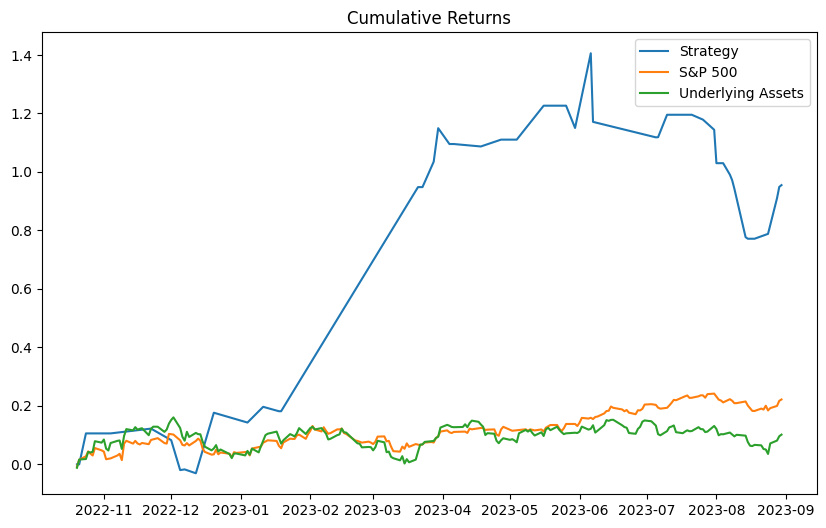

In [31]:
plt.figure(figsize=(10,6))
cum_rets = (1 + returns_df["normalized_returns"]).cumprod()-1
plt.plot(cum_rets, label="Strategy")
plt.plot(cum_spy_returns, label="S&P 500")
plt.plot(cum_underlying, label="Underlying Assets")
plt.title("Cumulative Returns")
plt.legend()
plt.show()

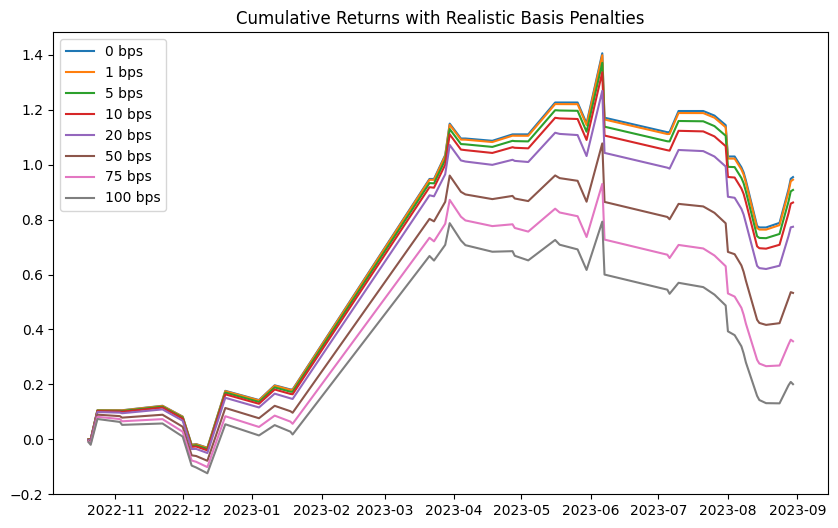

In [73]:
plt.figure(figsize=(10, 6))
for basis_penalty in [0, 1, 5, 10, 20, 50, 75, 100]:
    sub_rets = returns_df["normalized_returns"] - (basis_penalty / 10000)  # Convert bps to %
    cum_rets = (1 + sub_rets).cumprod() - 1
    plt.plot(returns_df.index, cum_rets, label=f"{basis_penalty} bps")
plt.legend()
plt.title("Cumulative Returns with Realistic Basis Penalties")
plt.show()

Text(0.5, 1.0, 'Distribution of Returns')

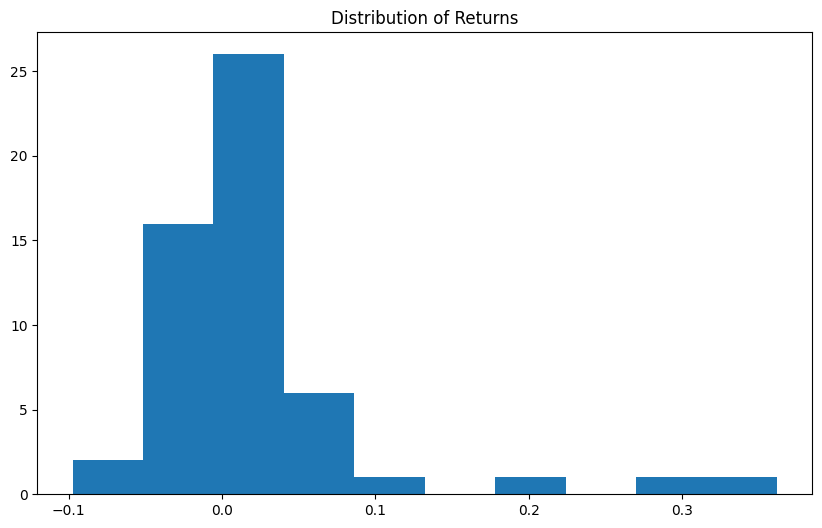

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(returns, bins=10)
plt.title("Distribution of Returns")

In [53]:
rf = df["rf"].mean()*252
comp_table = {}
for name, returns_type in zip(["Strategy", "S&P 500", "Underlying Assets"], [returns, spy, underlying]):
    comp_table[name] = {}
    sharpe = (returns_type.mean()*252 - rf) /(returns_type.std()* np.sqrt(252))
    mean = returns_type.mean()*252
    std = returns_type.std()* np.sqrt(252)
    comp_table[name]["Annualized Mean"] = mean
    comp_table[name]["Annualized Volatility"] = std
    comp_table[name]["Sharpe Ratio"] = sharpe

In [55]:
comp_table = pd.DataFrame(comp_table)
comp_table = comp_table.round(2)
comp_table

,Strategy,S&P 500,Underlying Assets
Annualized Mean,4.09,0.26,0.14
Annualized Volatility,1.19,0.17,0.21
Sharpe Ratio,3.40,1.41,0.49


In [71]:
basis_pens = {}
for basis_penalty in [0, 1, 5, 10, 20, 50, 75, 100]:
    basis_pens[basis_penalty] = {}
    sub_rets = returns_df["normalized_returns"] - (basis_penalty / 10000)  # Convert bps to %
    sharpe = (sub_rets.mean()*252 - rf) /(sub_rets.std()* np.sqrt(252))
    mean = sub_rets.mean()*252
    std = sub_rets.std()* np.sqrt(252)
    basis_pens[basis_penalty]["Annualized Mean"] = mean
    basis_pens[basis_penalty]["Annualized Volatility"] = std
    basis_pens[basis_penalty]["Sharpe Ratio"] = sharpe

In [72]:
basis_pens = pd.DataFrame(basis_pens)
basis_pens = basis_pens.round(2)
basis_pens = basis_pens.T
basis_pens.insert(0, "Basis Point", basis_pens.index)
basis_pens.reset_index(drop=True, inplace=True)
basis_pens

,Basis Point,Annualized Mean,Annualized Volatility,Sharpe Ratio
0,0,4.51,1.66,2.69
1,1,4.49,1.66,2.68
2,5,4.39,1.66,2.62
3,10,4.26,1.66,2.54
4,20,4.01,1.66,2.39
5,50,3.25,1.66,1.94
6,75,2.62,1.66,1.56
7,100,1.99,1.66,1.18
